# Note: This is the template version of Notebook 07

Your goal is to fill out all of the code in sections labelled "TODO" (search for "TODO").

There will often be more than one way to complete the code challenges (don't overthink this, just write code to do what the comments say, this might require researching/looking for examples, this is normal).

You can find an example of the "TODO" sections filled out in the original [Food Vision Milestone Project 1 notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb).

Everything below the following line is from said notebook.

If you have any questions, refer to the GitHub discussions page: https://github.com/mrdbourke/tensorflow-deep-learning/discussions

----

# Milestone Project 1: 🍔👁 Food Vision Big™

In the previous notebook ([transfer learning part 3: scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)) we built Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle | 
| Train data | 75,750 images | 7,575 images | 
| Test data | 25,250 images | 25,250 images | 
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training

But more on these later.

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard

## How you should approach this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to write more code.

> 📖 **Resource:** See the full set of course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

## Check GPU

For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training was introduced in [TensorFlow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html) (a very new feature at the time of writing).

What does **mixed precision training** do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the [TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible. 

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+. 

Google Colab offers P100, K80 and T4 GPUs, however, **the P100 and K80 aren't compatible with mixed precision training**.

Therefore before we proceed we need to make sure we have **access to a Tesla T4 GPU in our Google Colab instance**.

If you're not using Google Colab, you can find a list of various [Nvidia GPU compute capabilities on Nvidia's developer website](https://developer.nvidia.com/cuda-gpus#compute).

> 🔑 **Note:** If you run the cell below and see a P100 or K80, try going to to Runtime -> Factory Reset Runtime (note: this will remove any saved variables and data from your Colab instance) and then retry to get a T4.

In [1]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cff39ae9-2821-629b-7a7e-f3ba0bf7775b)


Since mixed precision training was introduced in TensorFlow 2.4.0, make sure you've got at least TensorFlow 2.4.0+.

In [2]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.8.2


## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [3]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-11 08:14:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-11 08:14:47 (23.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [6]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False` 
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format 
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [7]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete6T07RP/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete6T07RP/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Wonderful! After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [8]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize". 

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it. 

In [10]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [11]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)



  Image shape: (341, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 98
  Class name (str form): tiramisu
        


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [13]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(341, 512, 3), dtype=uint8, numpy=
array([[[  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0],
        ...,
        [  0,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  3,   3,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   5,   1]],

       ...,

       [[143,  75,  10],
        [149,  81,  16],
        [150,  85,  19],
        ...,
        [162,  88,  25],
        [150,  79,  17],
        [135,  65,   5]],

       [[144,  76,  11],
        [152,  84,  19],
        [145,  80,  16],
        ...,
        [126,  60,  12],
        [111,  50,   3],
        [ 95,  37,   0]],

       [[145,  77,  14],
        [150,  82,  19],
        [139,  74,  10],
        ...,
        [ 89,  35,   

In [14]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

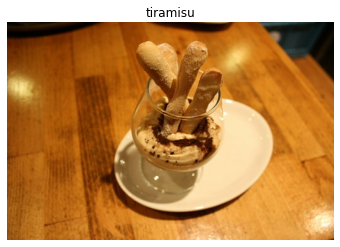

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Delicious!

Okay, looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.preprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model. 

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [0 3 0]
  [0 4 0]
  [0 4 0]]

 [[2 2 0]
  [2 2 0]
  [3 3 1]
  ...
  [1 3 0]
  [0 4 0]
  [0 4 0]]]...,
Shape: (341, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[2.         2.         0.        ]
  [2.947226   2.947226   0.947226  ]
  [4.         5.         0.        ]
  ...
  [1.         3.         0.        ]
  [0.01865775 2.757497   0.        ]
  [0.         4.         0.        ]]

 [[4.3504467  5.133929   0.7834822 ]
  [4.566964   5.3504467  1.        ]
  [4.783482   5.783482   0.7834822 ]
  ...
  [1.         3.         0.        ]
  [0.7989506  2.7989507  0.        ]
  [0.         4.2798424  0.2798424 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

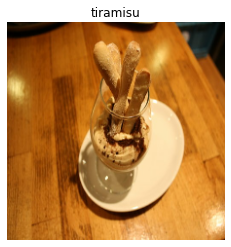

In [18]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

All this food visualization is making me hungry. How about we start preparing to model it?

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches elements in a target dataset, saving loading time (will only if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory) 

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying, 

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)
*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*


In [19]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

> 🔑 **Note:** You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to [`prefecth()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).

Onward.

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [21]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

> 📖 **Resource:** If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia page](https://en.wikipedia.org/wiki/Precision_(computer_science)) (and accompanying resources). 

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [22]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [23]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

Great, since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model) 
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*

To build the feature extraction model (covered in [Transfer Learning in TensorFlow Part 1: Feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb)), we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [25]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [26]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [27]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

> 🔑 **Note:** The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

## TODO: Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [29]:
# Fit the feature extraction model for 3 epochs with tensorboard and model checkpoint callbacks
model.fit(train_data, 
          epochs = 3, 
          steps_per_epoch = len(train_data), 
          validation_data = test_data, 
          validation_steps = int(0.15 * len(test_data)), 
           callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_all_data_feature_extract"),
                            model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220911-082559
Epoch 1/3
2368/2368 [==============================] - 205s 75ms/step - loss: 1.8233 - accuracy: 0.5559 - val_loss: 1.2325 - val_accuracy: 0.6814
Epoch 2/3
2368/2368 [==============================] - 169s 71ms/step - loss: 1.2927 - accuracy: 0.6674 - val_loss: 1.1298 - val_accuracy: 0.6909
Epoch 3/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.1440 - accuracy: 0.7018 - val_loss: 1.0881 - val_accuracy: 0.7058


Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?

In [30]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 50s 63ms/step - loss: 1.0862 - accuracy: 0.7067


[1.0861537456512451, 0.7067326903343201]

## TODO: Save the whole model to file

In [31]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model.save("food_vision_milestone_project_own/")

In [32]:
# Load model previously saved above
load_model = tf.keras.models.load_model("food_vision_milestone_project_own")

In [33]:
# Check the layers in the base model and see what dtype policy they're using
for layer in load_model.layers[1].layers[:5]:
  print("""Name: {}
           trainable: {}
           dtype : {}
           dtype_policy : {}
            """.format(layer.name, layer.trainable, layer.dtype, layer.dtype_policy))

Name: input_1
           trainable: True
           dtype : float32
           dtype_policy : <Policy "float32">
            
Name: rescaling
           trainable: False
           dtype : float32
           dtype_policy : <Policy "mixed_float16">
            
Name: normalization
           trainable: False
           dtype : float32
           dtype_policy : <Policy "mixed_float16">
            
Name: stem_conv_pad
           trainable: False
           dtype : float32
           dtype_policy : <Policy "mixed_float16">
            
Name: stem_conv
           trainable: False
           dtype : float32
           dtype_policy : <Policy "mixed_float16">
            


In [34]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = load_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 52s 63ms/step - loss: 1.0862 - accuracy: 0.7067


[1.0861542224884033, 0.7067326903343201]

In [35]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

True

## TODO: Preparing our model's layers for fine-tuning

**Next:** Fine-tune the feature extraction model to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf).

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [36]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-09-11 08:37:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  95.3MB/s    in 0.2s    

2022-09-11 08:37:41 (95.3 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [37]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [38]:
# Load and evaluate downloaded GS model
load_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")
result_load_gs_model = load_gs_model.evaluate(test_data)

790/790 [==============================] - 52s 63ms/step - loss: 1.0881 - accuracy: 0.7065


In [39]:
# Get a summary of the downloaded model
load_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [40]:
# How does the loaded model perform? (evaluate it on the test dataset)


In [41]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in load_gs_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [42]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in load_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [43]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
# YOUR_CODE_HERE
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                           patience = 3)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
# YOUR_CODE_HERE
checkpoint_path = "fine_tune_checkpoint/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                                               monitor = "val_loss", 
                                                               save_best_only = True)

In [44]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
# YOUR_CODE_HERE
load_gs_model.compile(loss = "sparse_categorical_crossentropy", 
                      optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                      metrics = ["accuracy"])

In [45]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE
history_all_data_fine_tune = load_gs_model.fit(train_data, 
                                               epochs = 100, 
                                               steps_per_epoch = len(train_data), 
                                               validation_data = test_data, 
                                               validation_steps = int(0.15 * len(test_data)), 
                                               callbacks = [create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_all_data_feature_extract"),
                            model_checkpoint_callback, 
                            early_stopping_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220911-083919
Epoch 1/100
2368/2368 [==============================] - 382s 154ms/step - loss: 0.9239 - accuracy: 0.7514 - val_loss: 0.8047 - val_accuracy: 0.7720
Epoch 2/100
2368/2368 [==============================] - 367s 154ms/step - loss: 0.5793 - accuracy: 0.8400 - val_loss: 0.7681 - val_accuracy: 0.7908
Epoch 3/100
2368/2368 [==============================] - 330s 139ms/step - loss: 0.3295 - accuracy: 0.9064 - val_loss: 0.8334 - val_accuracy: 0.7852
Epoch 4/100
2368/2368 [==============================] - 330s 139ms/step - loss: 0.1740 - accuracy: 0.9485 - val_loss: 0.9624 - val_accuracy: 0.7812
Epoch 5/100
2368/2368 [==============================] - 329s 138ms/step - loss: 0.1067 - accuracy: 0.9665 - val_loss: 1.0570 - val_accuracy: 0.7773


In [46]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
load_gs_model.save("final_model_that_beats_the_paper")

In [47]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
result = load_gs_model.evaluate(test_data)
result

790/790 [==============================] - 50s 63ms/step - loss: 1.0675 - accuracy: 0.7783


[1.0674635171890259, 0.778257429599762]

## TODO: View training results on TensorBoard

**To do:** Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.


In [ ]:
# YOUR_CODE_HERE
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

## TODO: Evaluate your trained model

Some ideas you might want to go through:
1. Find the precision, recall and f1 scores for each class (all 101).
2. Build a confusion matrix for each of the classes.
3. Find your model's *most wrong* predictions (those with the highest prediction probability but the wrong prediction).

See the evaluation section at the end of [Transfer Learning Part 3: Scaling Up for more](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb).

# Now we are going to Evaluate with custom test Data

In [48]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-09-11 09:13:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   193MB/s    in 13s     

2022-09-11 09:13:46 (121 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [49]:
from helper_functions import unzip_data

In [50]:
unzip_data("101_food_classes_10_percent.zip")

In [52]:
import os
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
import random

In [59]:
def view_random_image(target_folder, target_file):

  main_folder = target_folder + target_file
  random_image = random.sample(os.listdir(main_folder), 1)

  img = mpimage.imread(main_folder +"/"+ random_image[0])
  plt.imshow(img)
  plt.axis(False)
  plt.title(target_file)

  print(f"Image shape {img.shape}")
  return img

Image shape (384, 512, 3)


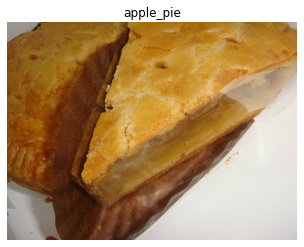

In [62]:
img = view_random_image(target_folder = "101_food_classes_10_percent/test/", 
                        target_file = "apple_pie")

In [75]:
test_data_custom = tf.keras.preprocessing.image_dataset_from_directory("101_food_classes_10_percent/test/", 
                                                                label_mode = "categorical", 
                                                                image_size = (224, 224), 
                                                                shuffle = False)

Found 25250 files belonging to 101 classes.


In [77]:
pred_probs_final = load_gs_model.predict(test_data_custom, verbose = 1)


790/790 [==============================] - 83s 102ms/step


In [81]:
pred_classes_final = pred_probs_final.argmax(axis = 1)

In [82]:
pred_classes_final[:10]

array([52,  0,  0,  0,  0,  0,  0, 46,  2, 41])

In [80]:
y_labels = []
for images, labels in test_data_custom.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [83]:
len(y_labels), len(pred_classes_final)

(25250, 25250)

In [84]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes_final)
sklearn_accuracy

0.7637227722772277

In [85]:
# Get the class names
class_names = test_data_custom.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [86]:
#The `classification_report()` outputs the precision, recall and f1-score's per class.
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes_final))

              precision    recall  f1-score   support

           0       0.64      0.54      0.59       250
           1       0.80      0.72      0.76       250
           2       0.83      0.85      0.84       250
           3       0.93      0.69      0.79       250
           4       0.78      0.66      0.72       250
           5       0.67      0.69      0.68       250
           6       0.83      0.88      0.85       250
           7       0.86      0.90      0.88       250
           8       0.57      0.63      0.60       250
           9       0.81      0.65      0.72       250
          10       0.70      0.74      0.72       250
          11       0.87      0.76      0.81       250
          12       0.82      0.87      0.84       250
          13       0.68      0.80      0.74       250
          14       0.79      0.79      0.79       250
          15       0.59      0.72      0.65       250
          16       0.01      0.01      0.01       250
          17       0.01    

In [87]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes_final, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6428571428571429,
  'recall': 0.54,
  'f1-score': 0.5869565217391305,
  'support': 250},
 '1': {'precision': 0.7964601769911505,
  'recall': 0.72,
  'f1-score': 0.7563025210084032,
  'support': 250},
 '2': {'precision': 0.8287937743190662,
  'recall': 0.852,
  'f1-score': 0.8402366863905325,
  'support': 250},
 '3': {'precision': 0.9301075268817204,
  'recall': 0.692,
  'f1-score': 0.7935779816513762,
  'support': 250},
 '4': {'precision': 0.7757009345794392,
  'recall': 0.664,
  'f1-score': 0.7155172413793103,
  'support': 250},
 '5': {'precision': 0.6745098039215687,
  'recall': 0.688,
  'f1-score': 0.6811881188118811,
  'support': 250},
 '6': {'precision': 0.8295454545454546,
  'recall': 0.876,
  'f1-score': 0.8521400778210118,
  'support': 250},
 '7': {'precision': 0.8615384615384616,
  'recall': 0.896,
  'f1-score': 0.8784313725490197,
  'support': 250},
 '8': {'precision': 0.5703971119133574,
  'recall': 0.632,
  'f1-score': 0.5996204933586339,
  'support': 

In [88]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.5869565217391305,
 'baby_back_ribs': 0.7563025210084032,
 'baklava': 0.8402366863905325,
 'beef_carpaccio': 0.7935779816513762,
 'beef_tartare': 0.7155172413793103,
 'beet_salad': 0.6811881188118811,
 'beignets': 0.8521400778210118,
 'bibimbap': 0.8784313725490197,
 'bread_pudding': 0.5996204933586339,
 'breakfast_burrito': 0.7212389380530974,
 'bruschetta': 0.7223300970873786,
 'caesar_salad': 0.809421841541756,
 'cannoli': 0.8433268858800773,
 'caprese_salad': 0.7362637362637362,
 'carrot_cake': 0.788,
 'ceviche': 0.645045045045045,
 'cheese_plate': 0.01171875,
 'cheesecake': 0.007843137254901962,
 'chicken_curry': 0.673758865248227,
 'chicken_quesadilla': 0.7612293144208039,
 'chicken_wings': 0.8531746031746033,
 'chocolate_cake': 0.5888324873096448,
 'chocolate_mousse': 0.5673758865248226,
 'churros': 0.851782363977486,
 'clam_chowder': 0.836734693877551,
 'club_sandwich': 0.8396946564885496,
 'crab_cakes': 0.6951672862453532,
 'creme_brulee': 0.8252252252252252,
 '

In [89]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.989940
63,macarons,0.938124
64,miso_soup,0.914405
69,oysters,0.913386
54,hot_and_sour_soup,0.911340
...,...,...
22,chocolate_mousse,0.567376
77,pork_chop,0.529148
93,steak,0.448637
16,cheese_plate,0.011719


In [90]:
test_dir= "101_food_classes_10_percent/test/"

In [92]:
from helper_functions import load_and_prep_image

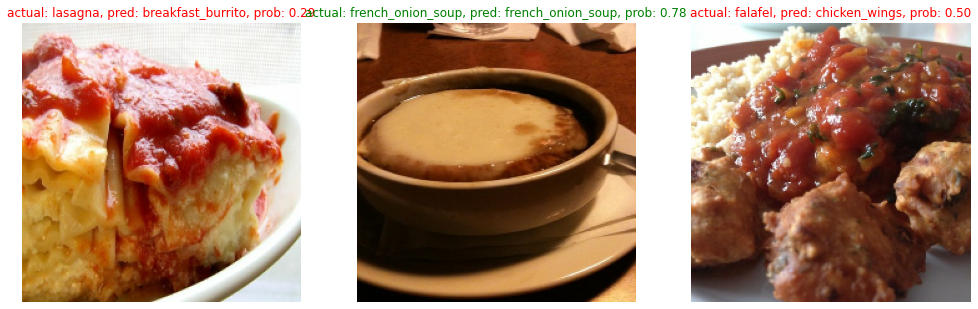

In [94]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3): #3 images will be picked

  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);


In [95]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [96]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes_final,
                        "pred_conf": pred_probs_final.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes_final]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.904506,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.981094,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.767254,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.995053,apple_pie,apple_pie
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.694451,apple_pie,apple_pie


In [97]:
# 3. Column for signifying if the prediction is correct
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.904506,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.981094,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.767254,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.995053,apple_pie,apple_pie,True
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.694451,apple_pie,apple_pie,True


In [98]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
4029,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False
4413,b'101_food_classes_10_percent/test/cheesecake/...,17,16,1.0,cheesecake,cheese_plate,False
4132,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False
4039,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False
14035,b'101_food_classes_10_percent/test/huevos_ranc...,56,66,1.0,huevos_rancheros,nachos,False
4242,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False
4040,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False
4130,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False
4126,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False
4007,b'101_food_classes_10_percent/test/cheese_plat...,16,17,1.0,cheese_plate,cheesecake,False


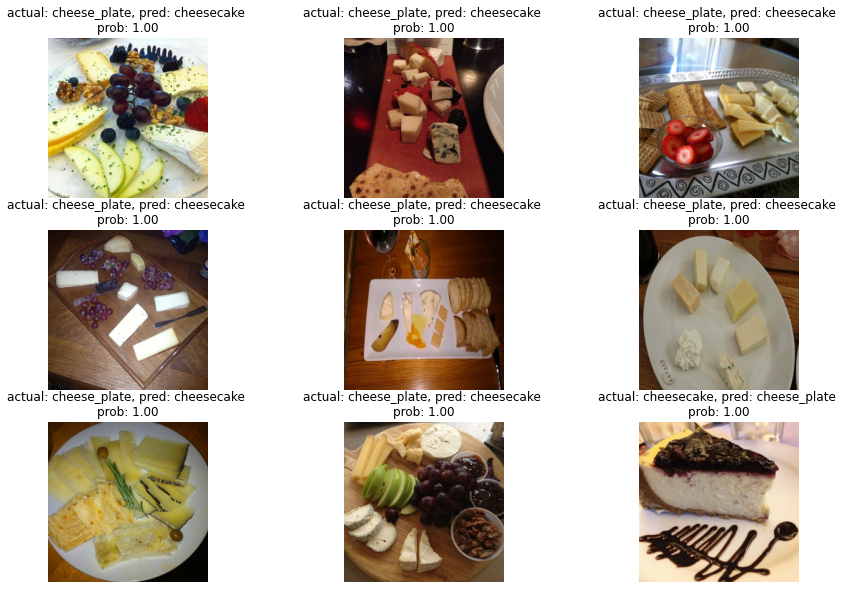

In [106]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  # print(row)
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row. Skip the first 4 parameters, last parameter in tuple
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [108]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-09-11 10:10:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-09-11 10:10:22 (104 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [109]:
# Download some custom images

unzip_data("custom_food_images.zip")

In [111]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

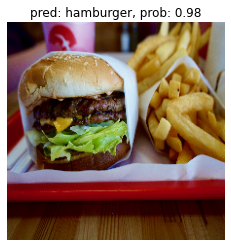

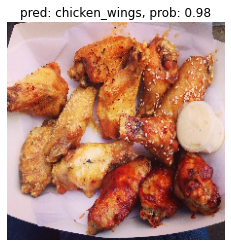

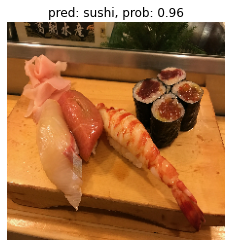

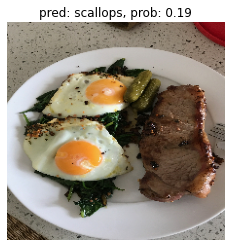

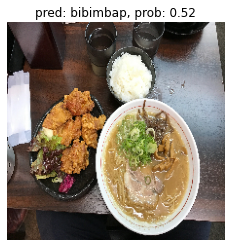

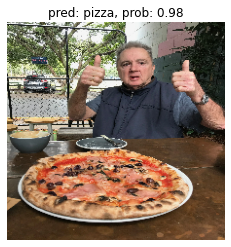

In [112]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

## 🛠 Exercises 

1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook ([Transfer Learning Part 3: Scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)). More specifically, it would be good to see:
  * A confusion matrix between all of the model's predictions and true labels.
  * A graph showing the f1-scores of each class.
  * A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    * For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label. 
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use [`EfficientNetB4`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB4) as the base model instead of `EfficientNetB0`. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
4. Name one important benefit of mixed precision training, how does this benefit take place?

## 📖 Extra-curriculum

* Read up on learning rate scheduling and the [learning rate scheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler). What is it? And how might it be helpful to this project?
* Read up on TensorFlow data loaders ([improving TensorFlow data loading performance](https://www.tensorflow.org/guide/data_performance)). Is there anything we've missed? What methods you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a gret round up of ideas.
* Read up on the documentation for [TensorFlow mixed precision training](https://www.tensorflow.org/guide/mixed_precision). What are the important things to keep in mind when using mixed precision training?